Manel Azoun 84966753\
Emma Gjøen 74324823\
Srijan Ravisankar 86992831\
Thayantha Sritharan 38664397

# Data Science Project - Final Report

## Introduction
A UBC research group studying player behaviours in video games and does so by operating a Minecraft server where player activity is recorded to understand engagement and contribution patterns. Minecraft is like a creative playground where one can explore, build, and have adventures in a virtual world without set rules or goals, making it a versatile platform for studying player behaviour. The research group wants to manage its server resources according to the demands, and they want to recruit more players to collect data on. In order to recruit more players, the stakeholder wants to know which “kinds” of players are most likely to contribute a large amount of data, so that they can be targeted in the recruiting efforts. In this report, we plan to help with this by the analysis of the following question below.

---

#### Question

*Which types of players, based on experience, age, and gender, are most likely to contribute substantial data (playing one hour or more)?* The response variable is `contributor` (which will be created after data wrangling), and the explanatory variables are `exeperience`, `age`, and `gender` and `start_day`. Identifying and predicting contributors in the data will help the research group focus its recruitment efforts on players most likely to provide valuable data.

---

### Data Description
We were given two datasets: "Players" and "Sessions". The Players dataset has one row for each individual player. The Sessions dataset has one row for each played session. One player can be part of several sessions. Due to the choice of explanatory and response variables in our question, we only need to use the Players dataset.

Players Dataset: `players_data` contains demographic information of each player, collected when the players register for the Minecraft server.
- Observations: 196 
- Variables: 9

In [24]:
#Load necessary libraries
library(tidyverse)
library(dplyr) 
library(ggplot2) 
library(repr)
library(tidymodels)
library(patchwork) #to display some plots next to each other

In [25]:
#Coded table describing the variables (not included in the word limit)

players_variable_summary <- tibble(Variable_name = c("experience", "suscribe", "hashedEmail",
                                        "played_hours",	"name",	"gender", "age", "individualId", "organizationName"), 
                           Variable_description = c("Player’s Minecraft experience", "Whether the player is subscribed for server emails", 
                                                    "Encrypted players’ email for anonymity", "Hours the player has spent on the server", 
                                                    "Player’s in-name game", "Player’s gender", "Player’s age", "Identifier of the player",
                                                    "Organization of the player"),
                           Variable_type = c("Categorical (character)", "Logical", "Categorical (character)", "Numerical", "Categorical (character)", 
                                             "Categorical (character)", "Numerical", "Logical", "Logical")) 
players_variable_summary

Variable_name,Variable_description,Variable_type
<chr>,<chr>,<chr>
experience,Player’s Minecraft experience,Categorical (character)
suscribe,Whether the player is subscribed for server emails,Logical
hashedEmail,Encrypted players’ email for anonymity,Categorical (character)
⋮,⋮,⋮
age,Player’s age,Numerical
individualId,Identifier of the player,Logical
organizationName,Organization of the player,Logical


#### Why 1 hour is chosen as the cutoff?

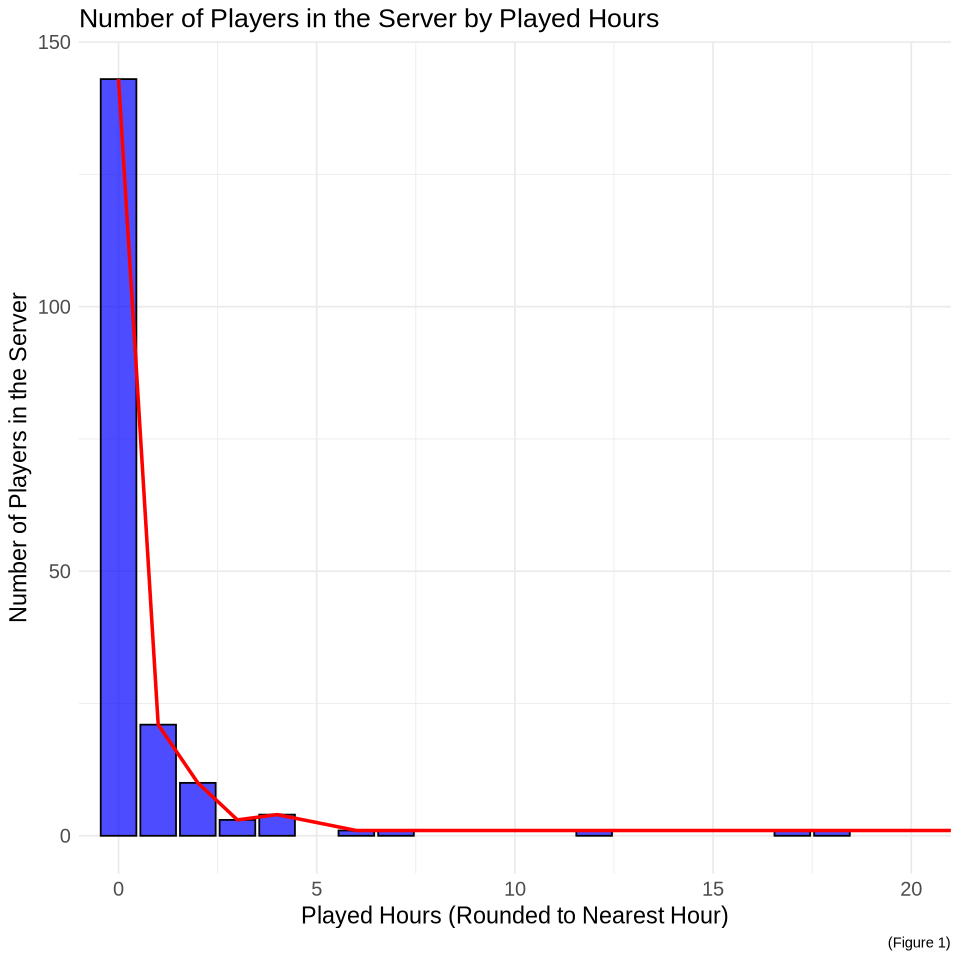

In [52]:
hourly_data <- players_data |>
  mutate(rounded_hours = round(played_hours)) |>
  group_by(rounded_hours) |>
  summarise(number_of_players = n())

ggplot(hourly_data, aes(x = rounded_hours, y = number_of_players)) +
  geom_bar(stat = "identity", fill = "blue", color = "black", alpha = 0.7) +
  geom_line(aes(x = rounded_hours, y = number_of_players), color = "red", size = 1) + 
  labs(title = "Number of Players in the Server by Played Hours",
       x = "Played Hours (Rounded to Nearest Hour)",
       y = "Number of Players in the Server",
       caption = "(Figure 1)") +
  coord_cartesian(xlim = c(0, 20)) +
  theme_minimal() +
  theme(plot.title = element_text(size = 16),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

From the graph, we see that majority of players have played for fewer than one hour. This is evident from the bar chart, where the count of players between hour 0 and hour 1 significantly outweighs the counts in subsequent hours.

Therefore, the cutoff is based on a clear observation of the distribution. By analyzing the bar chart, we can see that the frequency drops sharply after 1 hour, indicating a distinct shift in players' behavior/action. We can infer that players who exceed this threshold are likely to be more committed or regular users, and thus will contribute to the large amount of data.

This decision helps to create logical and interpretable groups such as contributors and non-contributors for analysis or intervention.

## Methods & Results

In this section we will load the dataset, wrangle it to a tidy format and perform our analysis. We will reason the steps taken along the way.

In [53]:
#Displaying the data for data analysis
#Load the data sets 
players_url <- "https://raw.githubusercontent.com/EmmaGjoen/data_science_group_project/refs/heads/main/players.csv"
players_data <- read_csv(players_url)

#Select only relevant columns in players_data
players_data <- players_data |>
                select(-individualId, -organizationName)

head(players_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Wrangling
We extract the explanatory features stated in our question:  `experience`, `gender` and `age`. Their data types are adjusted to better represent their values: `contributor` and `experience` are converted to categorical variables as they consist of a limited number of categories, while age is restricted to whole numbers. The response variable, `contributor`, is derived based on the amount of played hours. The dataset remains in a tidy format, with each row representing an individual player

In [54]:
# Wrangling data 
wrangled_players_data <- players_data |>
  mutate(
    contributor = factor(if_else(played_hours >= 1, "Yes", "No")),
    experience = as.factor(experience),
    gender = as.factor(gender),
    age = as.integer(age),
  ) |>
  select(experience, gender, age, contributor)

wrangled_players_data

experience,gender,age,contributor
<fct>,<fct>,<int>,<fct>
Pro,Male,9,Yes
Veteran,Male,17,Yes
Veteran,Male,17,No
⋮,⋮,⋮,⋮
Amateur,Prefer not to say,17,No
Amateur,Male,17,Yes
Pro,Other,91,No


### Summarizations and visualizations
For `experience` and `gender` we count the number of players in each category as this gives an intuition for the distrubution of the players. For `age`we see that most players are around 19- 21, but that there are a few outliers that can affect our analysis.

In [31]:
#Summarizing data
#Counts of players by exprience
experience_distirbution <- wrangled_players_data |>
                              group_by(experience) |>
                              summarise(count = n())
experience_distirbution

#Counts of players by gender
gender_distribution <- wrangled_players_data|>
                          count(gender) 
gender_distribution

#Demograo
#Demographics of players by age
age_demo <- wrangled_players_data |>
                      summarise(
                        min_age = min(age),
                        max_age = max(age),
                        mean_age = mean(age),
                        median_age = median(age)
                      )
age_demo

#Counts of players by ages
age_distribution <- wrangled_players_data |>
                        group_by(age) |>
                        summarise(count = n()) |>
                        slice_max(count, n = 6)
age_distribution

#Proportion of contributors vs. non-contributors in the server
contributor_prop <- wrangled_players_data |>
                          count(contributor) |>
                          mutate(proportion = n / sum(n))
contributor_prop

experience,count
<fct>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


gender,n
<fct>,<int>
Agender,2
Female,37
Male,124
⋮,⋮
Other,1
Prefer not to say,11
Two-Spirited,6


min_age,max_age,mean_age,median_age
<int>,<int>,<dbl>,<dbl>
8,99,21.28061,19


age,count
<int>,<int>
17,75
21,18
22,15
20,14
23,13
24,10


contributor,n,proportion
<fct>,<int>,<dbl>
No,154,0.7857143
Yes,42,0.2142857


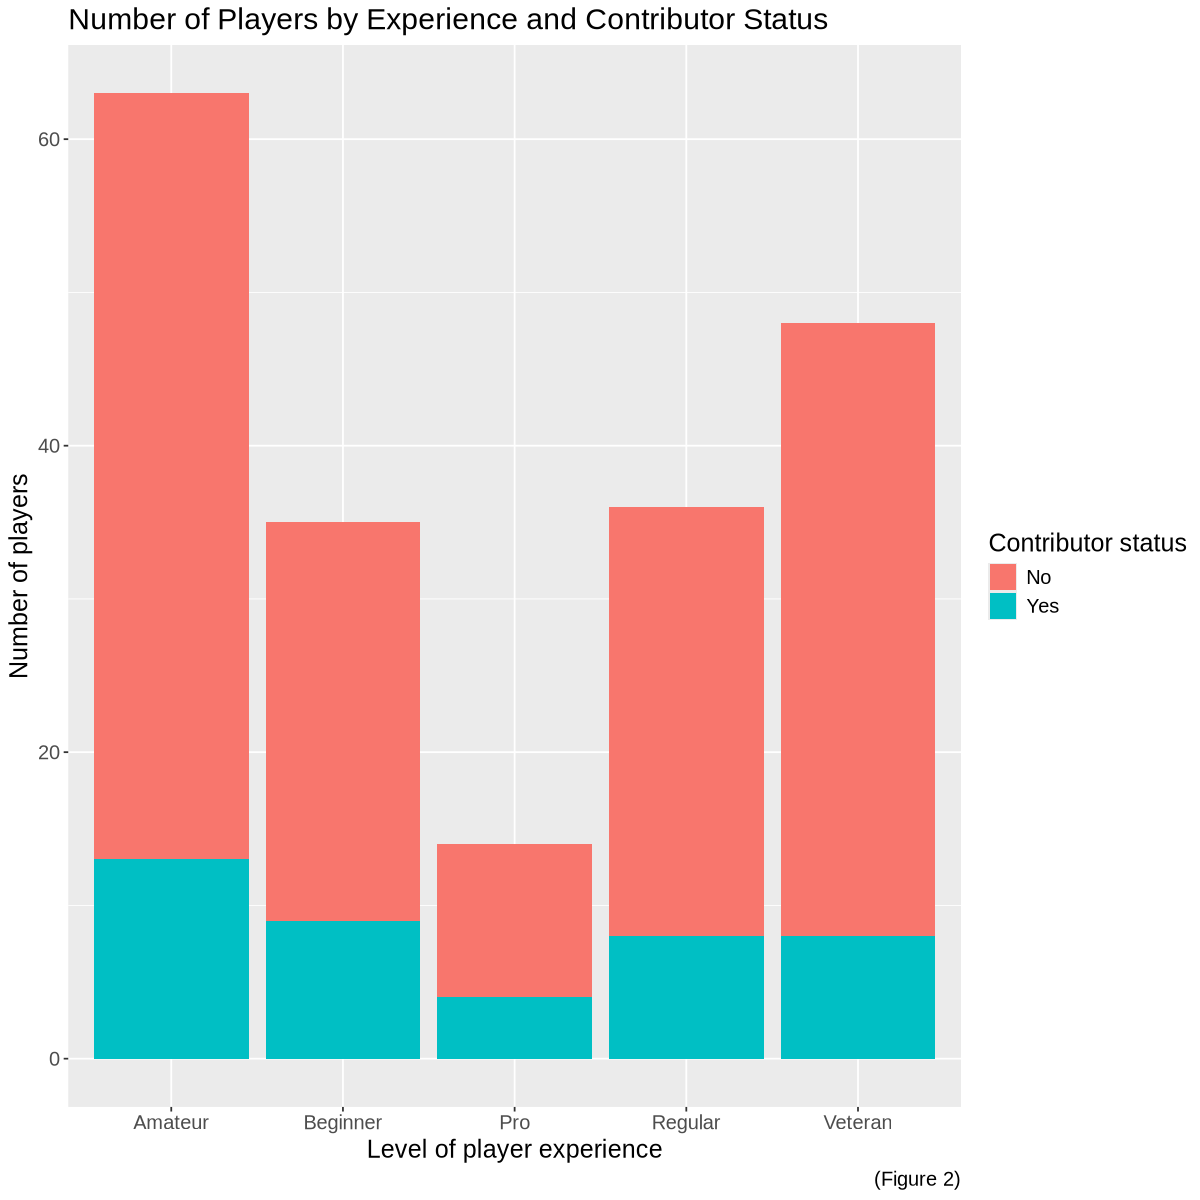

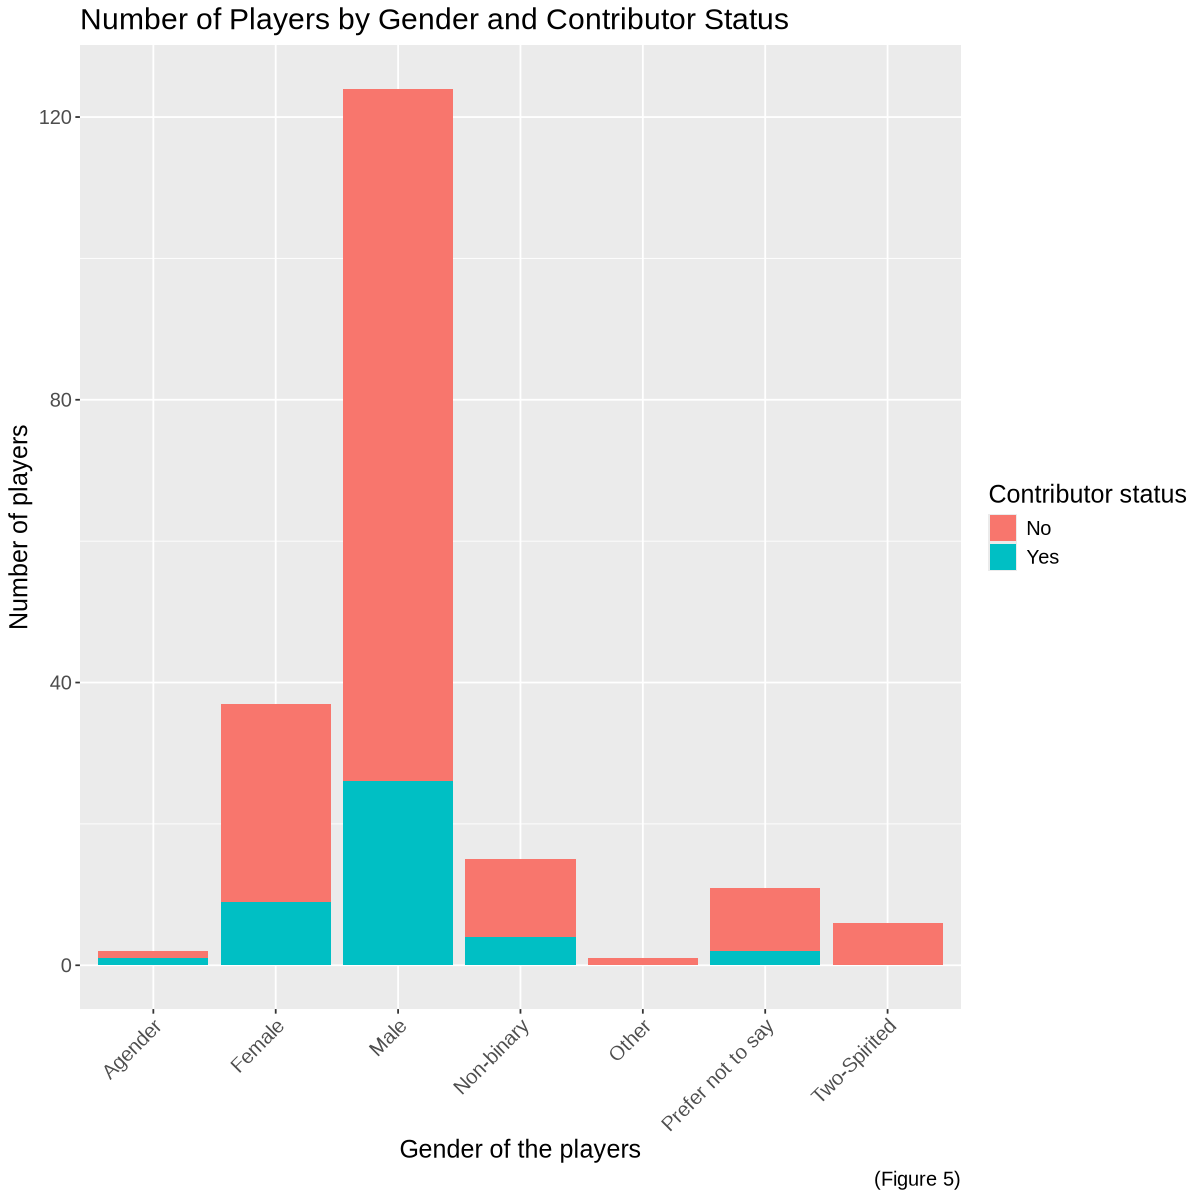

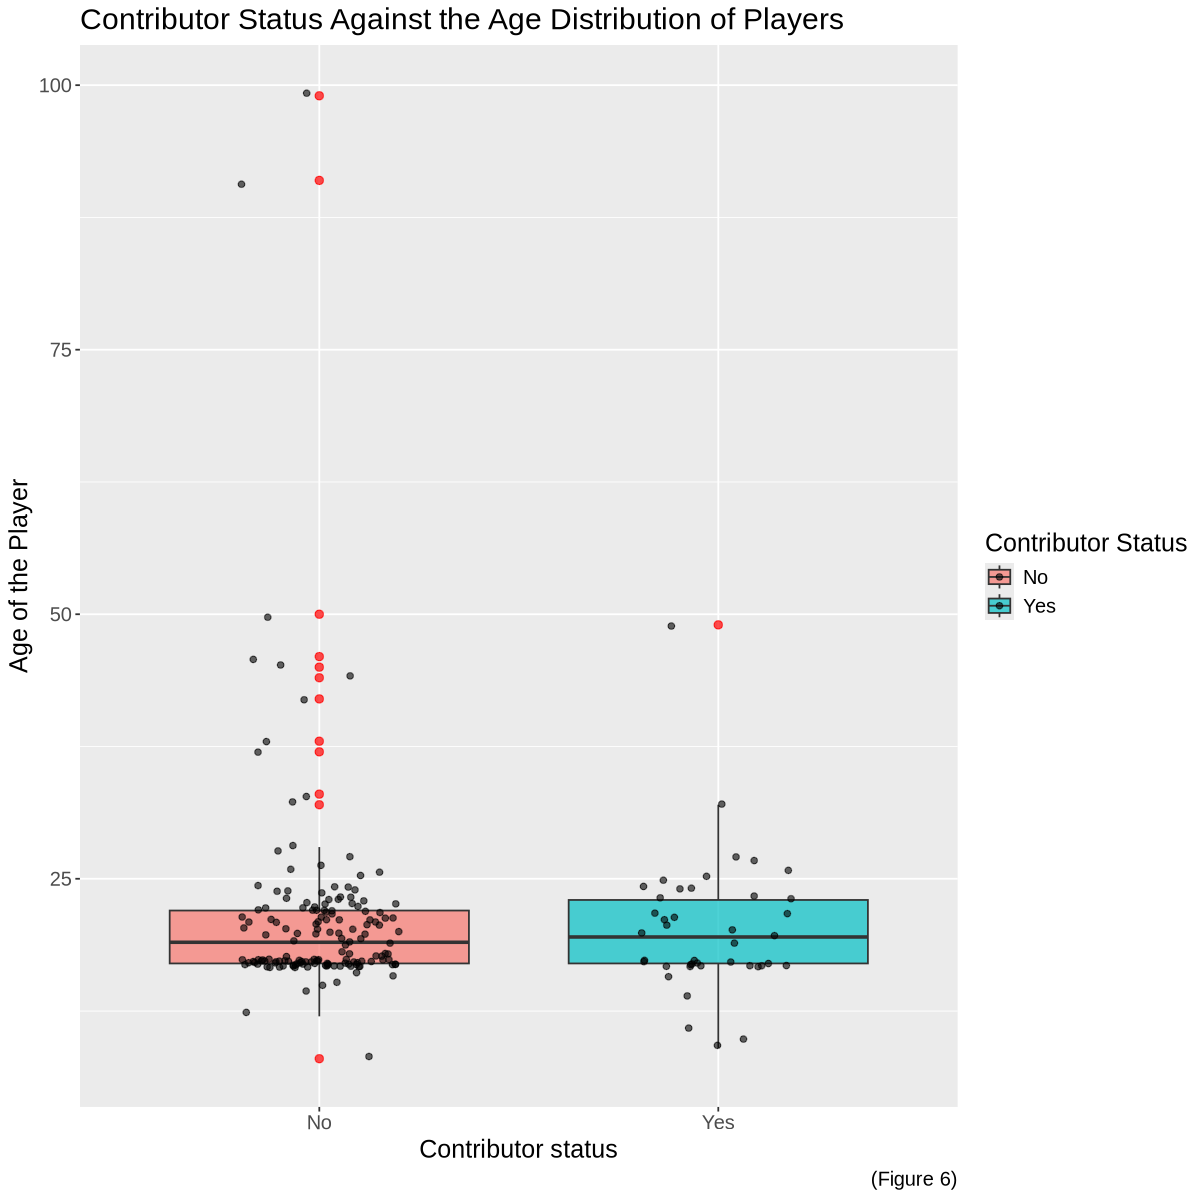

In [35]:
# Visualizing data
#Plot dimensions
options(repr.plot.height = 10, repr.plot.width = 10)

#Bar graph to decipher players' contributor status based on their experience
experience_plot <- ggplot(wrangled_players_data, aes(x = experience, fill = factor(contributor))) +
                        geom_bar(position = "stack") +
                        labs(
                            title = "Number of Players by Experience and Contributor Status",
                            x = "Level of player experience",
                            y = "Number of players",
                            fill = "Contributor status",
                            caption = "(Figure 2)"
                            ) + 
                        theme(text = element_text(size = 15))
experience_plot

#experience_proportion_plot <- ggplot(wrangled_players_data, aes(x = experience, fill = factor(contributor))) +
#                        geom_bar(position = "fill") +
#                        labs(
#                            title = "Proportion of contributors by experience",
#                            x = "Level of experience",
#                            y = "Proportion \n(of the total amount of players)",
#                            fill = "Contributor",
#                            caption = "(Figure 3)"
#                            ) + 
#                        theme(text = element_text(size = 15))

#experience_proportion_plot

#gender_pplot <- ggplot(wrangled_players_data, aes(x = gender, fill = factor(contributor))) +
#                   geom_bar(position = "fill") +
#                    labs(
#                        title = "Proportion of contributors by gender",
#                        x = "Gender",
#                       y = "Proportion \n(of the total amount of players)",
#                        fill = "Contributor",
#                       caption = "(Figure 4)"
#                   ) + 
#                   theme(text = element_text(size = 15),
#                        axis.text.x = element_text(angle = 45, hjust = 1))
#gender_pplot
### I think going with "count" proves why we need to exclude gender in our analysis
#### Gender will not be  used for further analysis and reasoning is given in the below cell

#Bar graph to decipher players' contributor status based on their gender
gender_plot <- ggplot(wrangled_players_data, aes(x = gender, fill = factor(contributor))) +
                    geom_bar(position = "stack") +
                    labs(
                        title = "Number of Players by Gender and Contributor Status",
                        x = "Gender of the players",
                        y = "Number of players",
                        fill = "Contributor status",
                        caption = "(Figure 5)"
                    ) + 
                    theme(text = element_text(size = 15),
                        axis.text.x = element_text(angle = 45, hjust = 1))
gender_plot

### DID THE PLOT WITH COUNT AND PROPORTION TO SEE ANY PATTERN
# ggplot(wrangled_players_data, aes(x = age_range, fill = factor(contributor))) +
#    geom_bar(position = "fill") +
#    labs(
#        title = "Proportion of Contributors by Age Range",
#        x = "Age Range ",
#        y = "Proportion",
#        fill = "Contributor",
#        caption = ("Figure 3")
#    ) + 
#    theme(text = element_text(size = 15),
#         axis.text.x = element_text(angle = 45, hjust = 1))

#Histogram to decipher players' contributor status based on their gender
# age_pplot <- ggplot(wrangled_players_data, aes(x = age_range, fill = factor(contributor))) +
#    geom_bar(position = "stack") +
#    labs(
#        title = "Number of Contributors by age_range",
#        x = "Age Range of players",
#        y = "Count",
#        fill = "Contributor",
#        caption = "(Figure 3)"
#    ) + 
#    theme(text = element_text(size = 15))
# age_pplot

#Box plot to decipher players' contributor status based on their age
age_plot <- ggplot(wrangled_players_data, aes(x = factor(contributor), y = age, fill = contributor)) +
                geom_boxplot(alpha = 0.7, outlier.size = 2, outlier.color = "red") +
                geom_jitter(width = 0.2, size = 1.5, alpha = 0.6, color = "black") +
                labs(
                    title = "Contributor Status Against the Age Distribution of Players",
                    x = "Contributor status",
                    y = "Age of the Player",
                    fill = "Contributor Status",
                    caption = "(Figure 6)"
                ) + 
                theme(text = element_text(size = 15))
age_plot

## need to remove it 
# ggplot(wrangled_players_data, aes(x = factor(contributor), fill = factor(contributor))) +
#    geom_bar(position = "stack", alpha = 0.8) +
#    facet_grid(gender ~ experience) +
#    labs(
#        title = "Contributors by Experience, Gender, and Status",
#        x = "Contributor Status (0 = No, 1 = Yes)",
#        y = "Count",
#        fill = "Contributor Status",
#        caption = ("Figure 5")
#    ) + 
#    theme(text = element_text(size = 15))



### Data analysis
- 75% of the wrangled dataset is used for model training, and the remaining 25% for testing.
- The levels in the `experience`variable is replaced by numbers from 1-5 in order to scale and centre both the explanatory variables.
- Since the stated question is a binary classification problem, the KNN model is used to predict new data.

In [36]:
# Setting seed at the start for reproducibility
set.seed(123)

#test_data <- players_data |>
#  mutate(
#    contributor = factor(if_else(played_hours >= 1, "Yes", "No")),
#    experience = as.factor(experience),
#    gender = as.factor(gender),
#    age = as.integer(age)
#  ) |>
#  select(experience, gender, age, contributor)
#test_data

# Splitting data into training and testing sets
players_split <- initial_split(wrangled_players_data, prop = 0.75, strata = contributor)
players_train <- training(players_split)
players_test <- testing(players_split)

#Creating recipe
players_recipe <- recipe(contributor ~ experience + gender + age, data = players_train) |>
                    step_scale(all_numeric_predictors()) |>
                    step_center(all_numeric_predictors()) |>
                    step_dummy(all_nominal_predictors())

#Defining KNN specification
players_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

### Tuning the classifier
 - 5-fold cross validation is used to choose the value of the K parameter. This way we have more data to evaulate the model on.
 - The dashed line in Figure 5 shows the best value of K

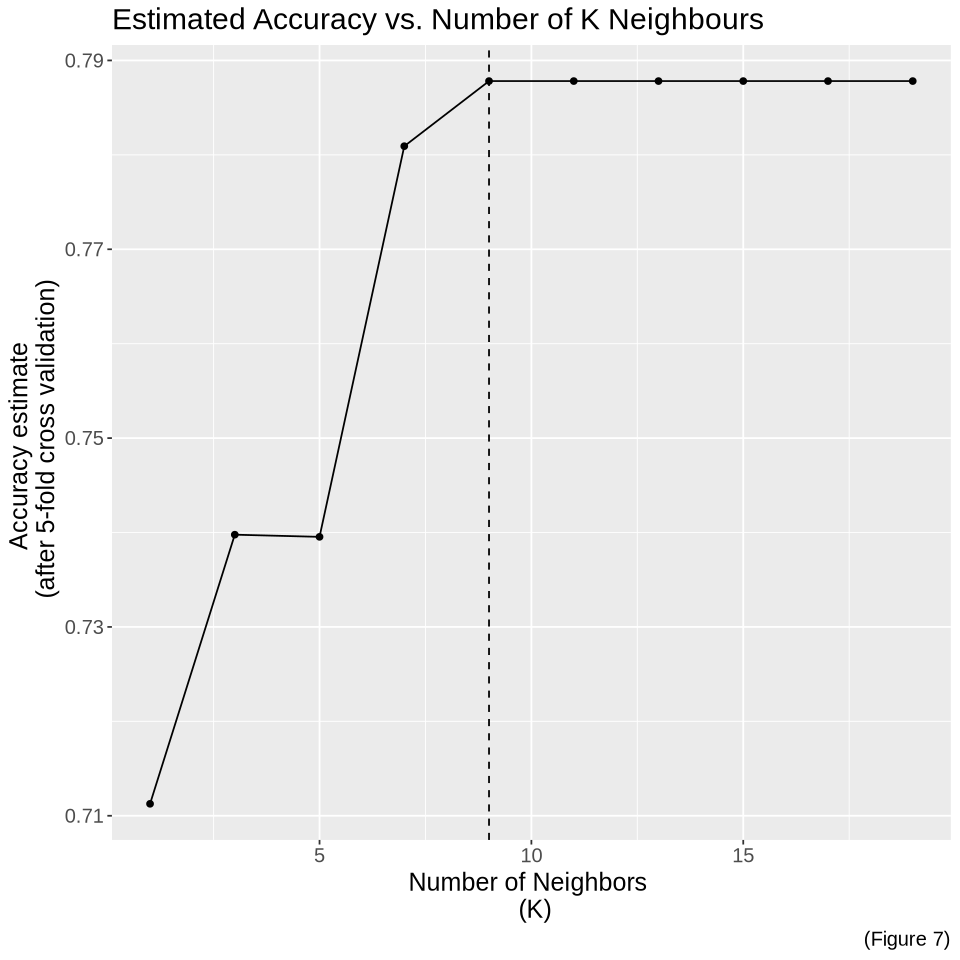

In [51]:
#Setting seed at the start for reproducibility
set.seed(123)

# 5-fold cross validation
players_folds <- vfold_cv(players_train, v = 5, strata = contributor)

#Grid
players_k_values <- tibble(neighbors = seq(from = 1, to = 20, by = 2))

#Tuning the model
players_knn_results <- workflow() |>
                        add_recipe(players_recipe) |>
                        add_model(players_knn_spec) |>
                        tune_grid(resamples = players_folds, grid = players_k_values) |>
                        collect_metrics()

#Extracting best k from results
accuracies <- players_knn_results |> 
                filter(.metric == "accuracy")

best_k <- accuracies |> 
            arrange(desc(mean)) |> 
            slice(1) |> 
            pull(neighbors)

#Plot accuracy vs k-value
options(repr.plot.height = 8, repr.plot.width = 8)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of Neighbors \n (K)",
                         y = "Accuracy estimate \n (after 5-fold cross validation)",
                         title = "Estimated Accuracy vs. Number of K Neighbours",
                        caption = "(Figure 7)") +
                    theme(text = element_text(size = 15)) + 
                    geom_vline(xintercept = best_k, linetype = "dashed")
accuracy_vs_k

### Evaluate on test-set
 - Using the defined parameters, the tuned model is fitted on the whole training dataset
 - The visualizations show two-and-two variables on the axes. The left visualizations show the predicted class, while the right visualization is the correct class.

In [39]:
#Setting seed at the start for reproducibility
set.seed(123)

#Define KNN specification with best k
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

#Creating workflow with final specification
final_knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(final_knn_spec) |>
    fit(players_train)

#Making predictions on the testing data
test_predictions <- predict(final_knn_fit, new_data = players_test) |>
    bind_cols(players_test)

In [55]:
# Setting seed at the start for reproducibility
set.seed(123)

# Evaluating test metrics
test_results <- test_predictions |>
    mutate(correctness = if_else(contributor == .pred_class, "Correct", "Incorrect"))
cat("Final test result: \n")
test_results

cat("\n")

test_accuracy <- test_results |>
  summarise(accuracy = mean(correctness == "Correct")) |>
  pull(accuracy)

cat("The accuracy of the test result is:", test_accuracy, "\n")
cat("Best k:", best_k, "\n")

# Calculating accuracy
accuracy_result <- test_predictions |>
  metrics(truth = contributor, estimate = .pred_class) |>
  filter(.metric == "accuracy")
cat("\nAccuracy:\n")
print(accuracy_result)

cat("\n")

# Calculating precision
precision_result <- test_predictions |>
  precision(truth = contributor, estimate = .pred_class)
cat("\nPrecision:\n")
print(precision_result)

cat("\n")

# Calculating recall
recall_result <- test_predictions |>
  recall(truth = contributor, estimate = .pred_class)
cat("\nRecall:\n")
print(recall_result)

cat("\n")

# Confusion matrix
confusion_matrix <- test_predictions |>
  conf_mat(truth = contributor, estimate = .pred_class)
cat("\nConfusion Matrix:\n")
print(confusion_matrix)

Final test result: 


.pred_class,experience,gender,age,contributor,correctness
<fct>,<fct>,<fct>,<int>,<fct>,<chr>
No,Veteran,Male,17,No,Correct
No,Amateur,Female,21,No,Correct
No,Regular,Male,21,No,Correct
⋮,⋮,⋮,⋮,⋮,⋮
No,Veteran,Male,17,No,Correct
No,Pro,Male,21,No,Correct
No,Amateur,Female,22,No,Correct



The accuracy of the test result is: 0.74 
Best k: 9 

Accuracy:
# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary          0.74


Precision:
# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.771


Recall:
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary         0.949


Confusion Matrix:
          Truth
Prediction No Yes
       No  37  11
       Yes  2   0


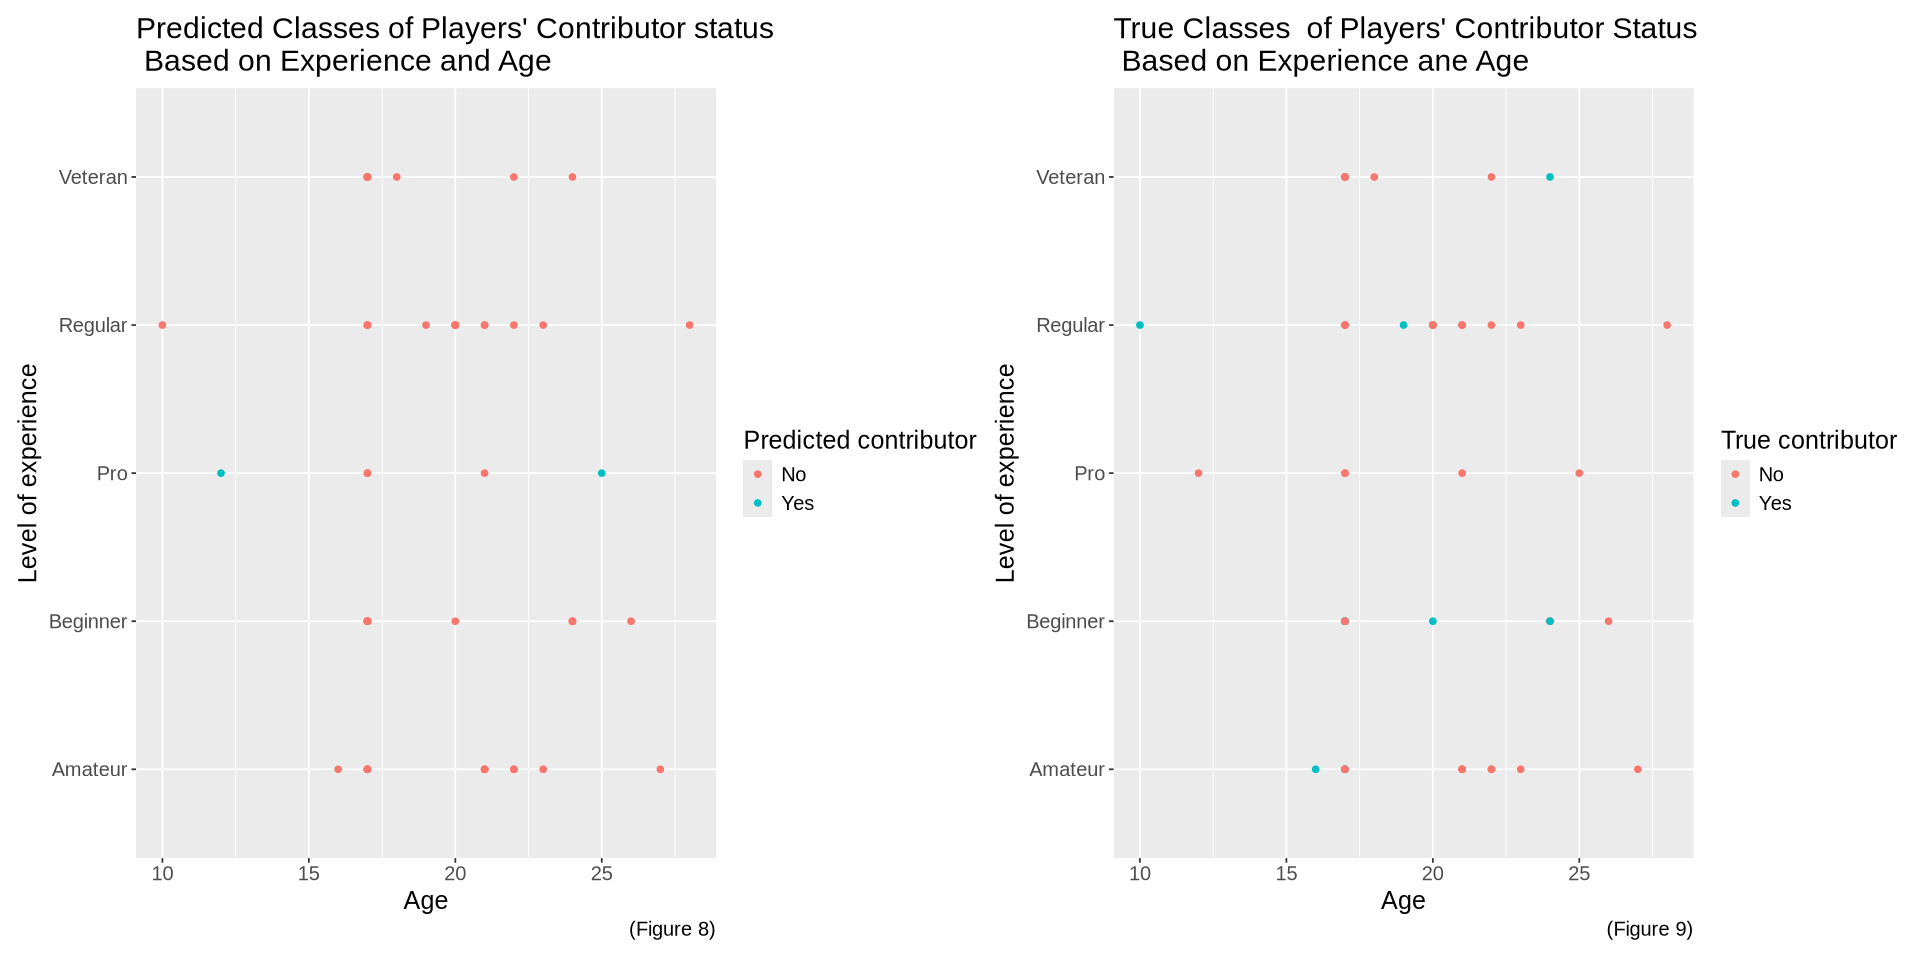

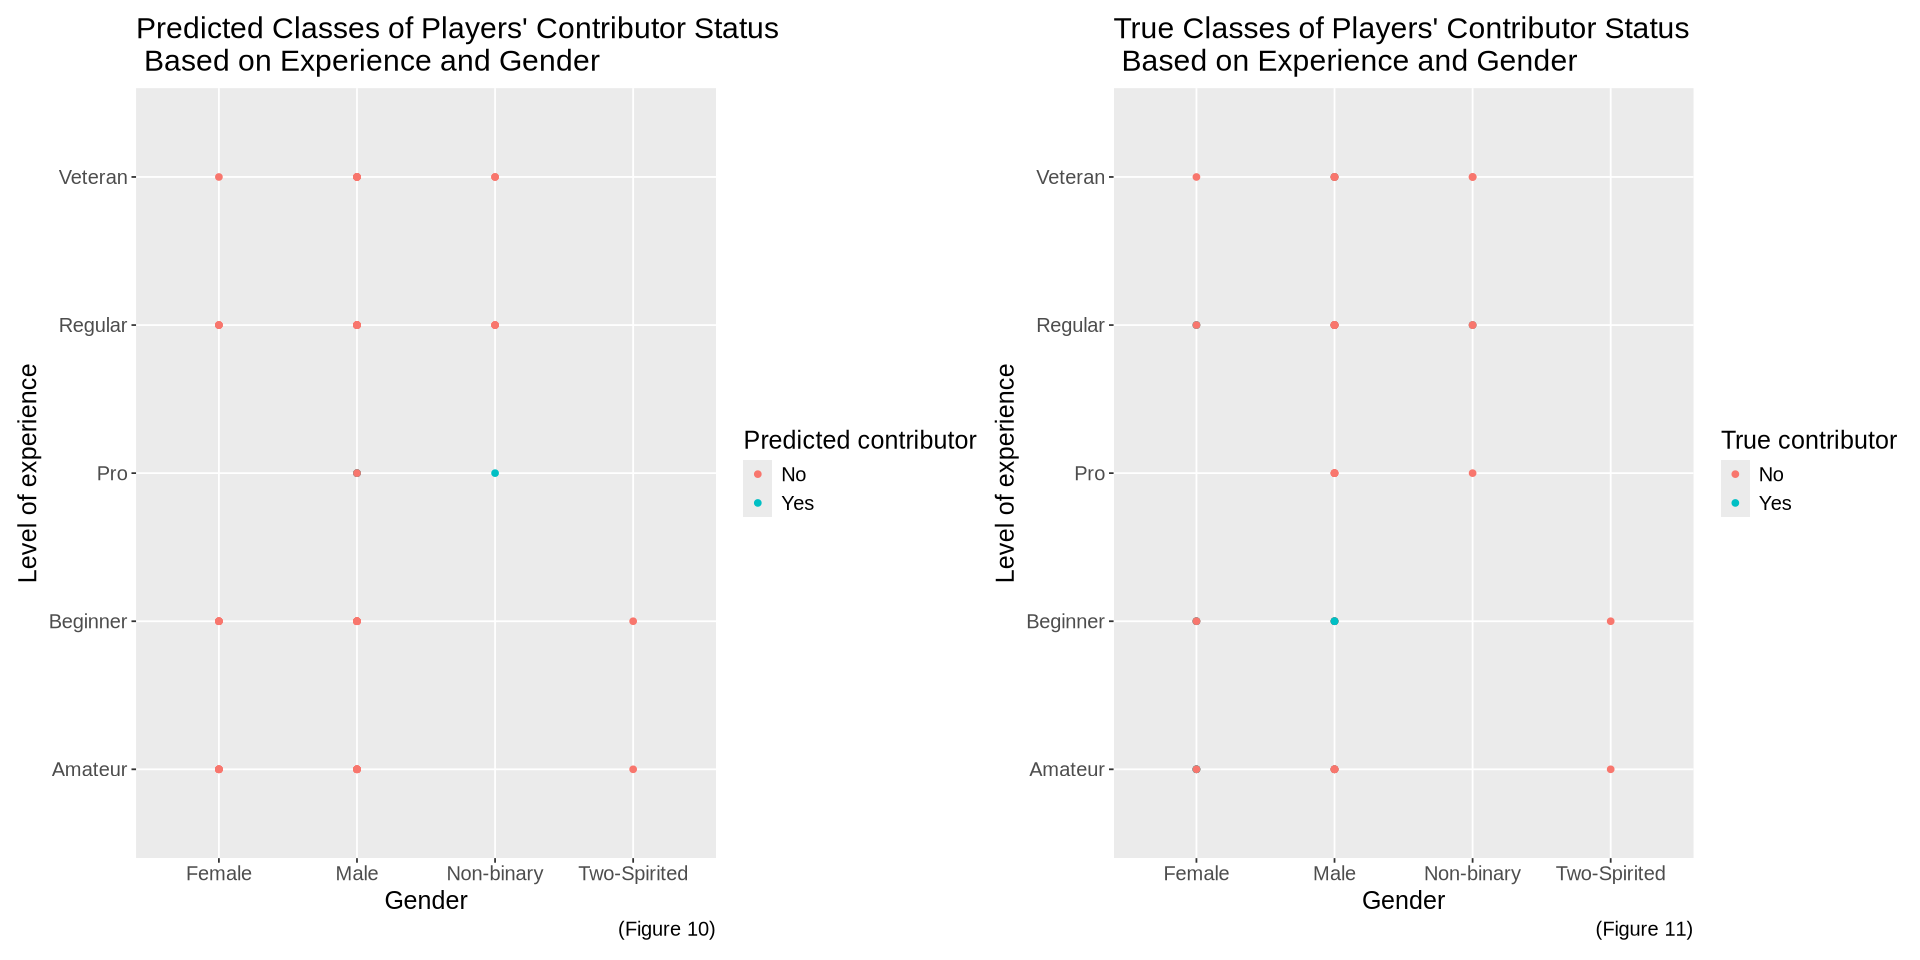

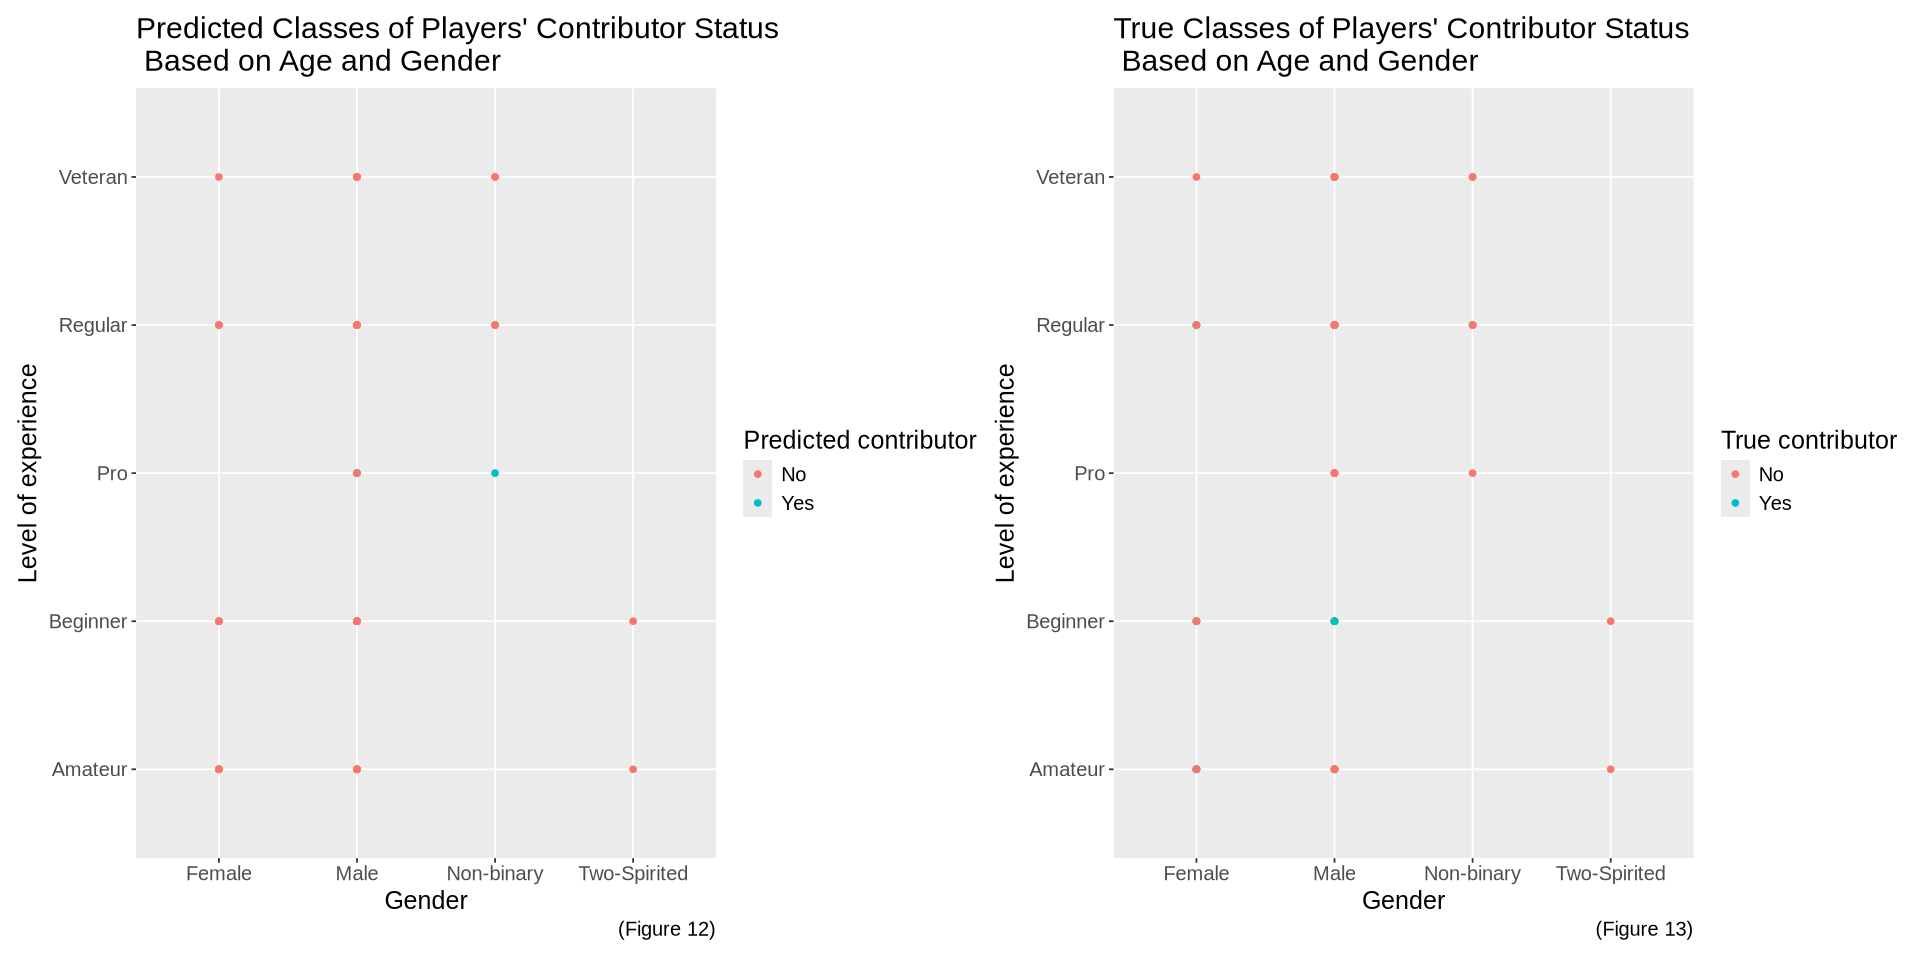

In [48]:
#Plotting the predictive analysis of the testing set

#Predictive plot of players' contributor status based on their experience and age
pred_plot_experience_vs_age <- test_predictions |>
    ggplot(aes(x=age, y=experience, color=.pred_class)) +
    geom_point() + 
    labs(x="Age",
         y="Level of experience",
         color="Predicted contributor",
         title="Predicted Classes of Players' Contributor status\n Based on Experience and Age",
         caption="(Figure 8)") +
    theme(text=element_text(size=15))

#True plot of players' contributor status based on their experience and age
true_plot_experience_vs_age <- test_predictions |>
    ggplot(aes(x=age, y=experience, color=contributor)) +
    geom_point() + 
    labs(x="Age",
         y="Level of experience",
         color="True contributor",
         title="True Classes  of Players' Contributor Status\n Based on Experience ane Age",
         caption="(Figure 9)") +
    theme(text=element_text(size=15))

#Predictive plot of players' contributor status based on their experience and gender
pred_plot_experience_vs_gender <- test_predictions |>
    ggplot(aes(x=gender, y=experience, color=.pred_class)) +
    geom_point() + 
    labs(x="Gender",
         y="Level of experience",
         color="Predicted contributor",
         title="Predicted Classes of Players' Contributor Status\n Based on Experience and Gender",
         caption="(Figure 10)") +
    theme(text=element_text(size=15))

#True plot of players' contributor status based on their experience and gender
true_plot_experience_vs_gender <- test_predictions |>
    ggplot(aes(x=gender, y=experience, color=contributor)) +
    geom_point() + 
    labs(x="Gender",
         y="Level of experience",
         color="True contributor",
         title="True Classes of Players' Contributor Status\n Based on Experience and Gender",
         caption="(Figure 11)") +
    theme(text=element_text(size=15))

#Predictive plot of players' contributor status based on their age and gender
pred_plot_age_vs_gender <- test_predictions |>
    ggplot(aes(x=gender, y=experience, color=.pred_class)) +
    geom_point() + 
    labs(x="Gender",
         y="Level of experience",
         color="Predicted contributor",
         title="Predicted Classes of Players' Contributor Status\n Based on Age and Gender",
         caption="(Figure 12)") +
    theme(text=element_text(size=15))

#True plot of players' contributor status based on their age and gender
true_plot_age_vs_gender <- test_predictions |>
    ggplot(aes(x=gender, y=experience, color=contributor)) +
    geom_point() + 
    labs(x="Gender",
         y="Level of experience",
         color="True contributor",
         title="True Classes of Players' Contributor Status\n Based on Age and Gender",
         caption="(Figure 13)") +
    theme(text=element_text(size=15))

# display the predicted and true classes next to each other
options(repr.plot.width = 16, repr.plot.height = 8)
pred_plot_experience_vs_age | true_plot_experience_vs_age
pred_plot_experience_vs_gender | true_plot_experience_vs_gender
pred_plot_age_vs_gender | true_plot_age_vs_gender

## **Discussion**

In this study, we analyzed player data to examine the likelihood of contributing large amounts of data (one hour or more) based on factors like experience, gender, and age. Using descriptive statistics and K-Nearest Neighbours (KNN) classification, we identified patterns in contributions across different demographic groups. The analysis revealed that experience did not strongly correlate with contribution levels. When we examine the proportion of contributions from players based on each experience type, we observe that the proportions fall within the range of 0.20 to 0.25. Although the overall proportions for each group are similar, it is important to consider subgroups. For instance, the "Amateur" subgroup has 64 observations in the dataset, while the "Pro" subgroup has only 14. In this case, we can be more confident in stating that "Amateur" players are more likely to contribute a larger amount of data compared to "Pro" players, due to the higher number of observations. This suggests that newer players may contribute more actively as part of their learning process, while more experienced players might not feel the need to contribute once they have achieved a certain level of proficiency. In addition, when we consider gender subgroups, we observe that 50% of "Agender" individuals contribute to the large data group, while the contribution proportions for "Male," "Female," "Non-binary," and "Prefer not to say" subcategories fall within the range of 0.20 to 0.27. It is worth noting that there were no contributors from the "Other" and "Two-spirited" gender subcategories. However, it is challenging to draw clear conclusions from these proportions because the data distribution across these subcategories is highly imbalanced. For instance, there are only 2 observations in the "Agender" subgroup, compared to 124 observations in the "Male" subgroup. As a result, any conclusions drawn from this visualization may be biased due to the underrepresentation of certain subgroups. Next on, the age analysis showed that most contributors fell within the adolescent age range of 13-23 years, but non-contributors showed more variation, with older individuals exhibiting outlier behaviours. This suggests that although younger players are more likely to contribute, age alone does not fully explain participation, and additional factors must be considered. 

The KNN model was trained using experience, gender, and age to classify players as contributors (played ≥1 hour) or non-contributors. We created side-by-side visualizations comparing the true class and the predicted class. These plots clearly demonstrate that the model performed well in classifying non-contributors, with most predictions aligning with the actual labels. To further evaluate the model, we calculated its precision, accuracy, and recall using the test dataset. These metrics provided a comprehensive understanding of the model’s strengths and limitations, particularly its strong ability to identify non-contributors while struggling with contributors. The model achieved an accuracy of 74%, with a precision of 0.771 and a recall of 0.949. The optimal value of k = 9 was selected through five-fold cross-validation, which showed the highest accuracy for this setting. The confusion matrix highlights that the model performs well at predicting non-contributors, with 37 true negatives and only 2 false positives. However, the model struggled with contributors, as indicated by 11 false negatives and 0 true positives. This discrepancy suggests that the dataset is imbalanced, with significantly fewer contributors compared to non-contributors, which likely biases the model toward predicting the majority class.Despite its limitations, the model offers valuable insights into player behavior. The high recall indicates that it identifies nearly all contributors but does so at the cost of lower precision, meaning that some non-contributors are incorrectly labeled as contributors. Future improvements could include  adding more features (e.g., the number of sessions played or other relevant variables) to help the model better distinguish between contributors and non-contributors. Additionally, collecting more data, especially from contributors, could help the model learn more about this group and make better predictions.


The findings were somewhat surprising, particularly regarding experience. One might expect more experienced players—such as veterans or professionals—to contribute more frequently, assuming they are more engaged with the platform. However, the data contradicted this, showing that amateur players had the highest contribution rates. This suggests that engagement may be driven by a desire to learn and explore rather than by a need to perfect skills. The gender-based results were mostly in line with expectations, with male and female players contributing at similar rates. However, the lower contribution rates among non-binary players were somewhat unexpected. While this may reflect broader trends of underrepresentation in gaming and tech spaces, it could also suggest that more inclusive features or outreach might be needed to better engage non-binary players. The age-based analysis confirmed that younger players contribute more often, but the presence of outliers within the non-contributor group suggests that other factors besides age influence participation. This finding indicates that age alone is insufficient to explain who contributes, and further exploration into additional player characteristics may provide more insight. The performance of the KNN model aligned with expectations for an imbalanced dataset. While it was successful at identifying non-contributors, its ability to correctly classify contributors was limited. This is a common challenge when working with imbalanced data, as the model is biased toward predicting the majority class, in this case, non-contributors.

The findings have several important implications for platforms that rely on user-generated contributions. Understanding who is most likely to contribute can inform strategies to engage different player groups. For instance, the higher contribution rates among amateur players suggest that new users might be more motivated to engage as part of their learning process. Platforms could design tutorials or beginner challenges to encourage continued participation from these users. On the other hand, more experienced players may need different types of engagement, such as incentives or features that cater to their established goals. Gender inclusivity is another area where these findings could have an impact. The relatively balanced contribution rates between male and female players suggest that gender may not be a significant barrier to participation. However, the lower participation rates among non-binary players highlight the need for more inclusive features, such as customizable gender options or specific outreach efforts to non-binary players. Age-based insights also suggest that younger players are more likely to contribute, which could be useful for platforms targeting younger audiences. To maintain engagement, these platforms might consider gamifying the contribution process or offering rewards to frequent contributors. The results from the KNN model also point to challenges in predictive modelling, particularly when dealing with imbalanced datasets. While the model excelled at predicting non-contributors, its ability to identify contributors was limited. This indicates that future models could benefit from techniques like oversampling or using algorithms designed to handle imbalanced classes. Additionally, incorporating more features, such as player behaviour or social interactions, could improve the accuracy of these models in predicting contributors.

The findings of this study lead to several avenues for future research. One of the most pressing areas is understanding the motivations behind player contributions. The high contribution rates among amateur players suggest that there may be intrinsic factors driving participation, such as a desire to improve, gain recognition, or build social connections within the community. Future research could explore these motivations in more depth to help platforms tailor their engagement strategies to different player types. Another area for further investigation is improving model accuracy. The KNN model’s performance was limited by class imbalance, and future studies could focus on using more advanced machine learning techniques, such as ensemble methods or neural networks, to enhance prediction accuracy. Additionally, incorporating more features—such as player behaviour, in-game interactions, or social network dynamics—could provide a more nuanced understanding of who is likely to contribute. This could help create more effective models for predicting contributions and fostering engagement across different player groups.




- https://www.geeksforgeeks.org/box-plot-in-r-using-ggplot2/
- https://recipes.tidymodels.org/articles/Simple_Example.html